# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 11 - Segmentação Semântica de Imagens

## U-Net

O U-net é construído sobre a rede totalmente convolucional de cima. Foi construído para fins médicos para encontrar tumores nos pulmões ou no cérebro. Ele também consiste em um codificador que reduz a amostra da imagem de entrada para um mapa de recursos e o decodificador que amostra o mapa de recursos para o tamanho da imagem de entrada usando camadas de deconvolução aprendidas.

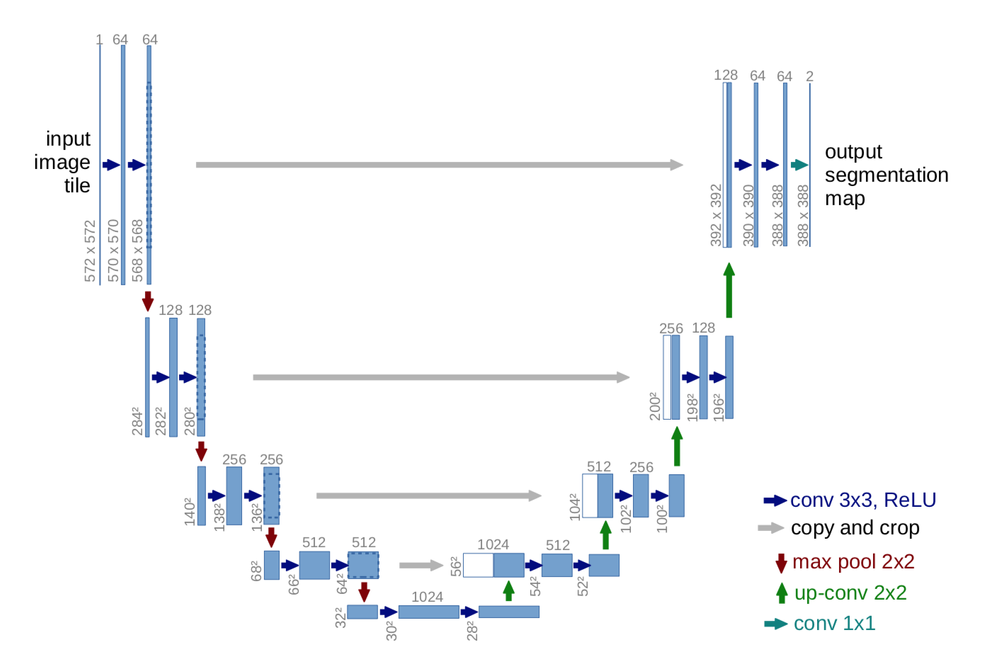

A principal contribuição da arquitetura U-Net são as conexões de atalho. Vimos acima no FCN que, como reduzimos a amostra de uma imagem como parte do codificador, perdemos muitas informações que não podem ser facilmente recuperadas na parte do codificador. A FCN tenta resolver isso obtendo informações das camadas de agrupamento antes da camada de feição final.

U-Net propõe uma nova abordagem para resolver este problema de perda de informação. Ele se propõe a enviar informações para cada camada de amostragem ascendente no decodificador a partir da camada de amostragem descendente correspondente no codificador, como pode ser visto na figura acima, capturando assim informações mais refinadas e, ao mesmo tempo, mantendo a computação baixa. Como as camadas no início do codificador teriam mais informações, elas reforçariam a operação de amostragem do decodificador, fornecendo detalhes finos correspondentes às imagens de entrada, melhorando muito os resultados. O artigo também sugeriu o uso de uma nova função de perda que discutiremos a seguir.

Ele pode ser dividido em um caminho de codificador-decodificador ou caminho expansivo de contração de forma equivalente.

Codificador (lado esquerdo): Consiste na aplicação repetida de duas convoluções 3x3. Cada conv é seguida por uma ReLU e normalização em lote. Em seguida, uma operação de agrupamento máximo de 2x2 é aplicada para reduzir as dimensões espaciais. Novamente, a cada passo de redução da resolução, dobramos o número de canais de recursos, enquanto cortamos pela metade as dimensões espaciais.




Caminho do decodificador (lado direito): Cada etapa no caminho expansivo consiste em um upsampling do mapa de recursos seguido por uma convolução de transposição 2x2, que reduz pela metade o número de canais de recursos. Também temos uma concatenação com o mapa de recursos correspondente do caminho de contratação e, geralmente, uma convolução 3x3 (cada uma seguida por uma ReLU). Na camada final, uma convolução 1x1 é usada para mapear os canais para o número desejado de classes.

Neste exemplo de U-Net, usaremos o seguinte conjunto de dados:
Mapear a água da enchente a partir de imagens de radar:

https://www.drivendata.org/competitions/81/detect-flood-water/page/385/

O conjunto de dados é composto por imagens SAR, com bandas Sentinel 1 VV e VH, e suas respectivas máscaras representando áreas alagadas.

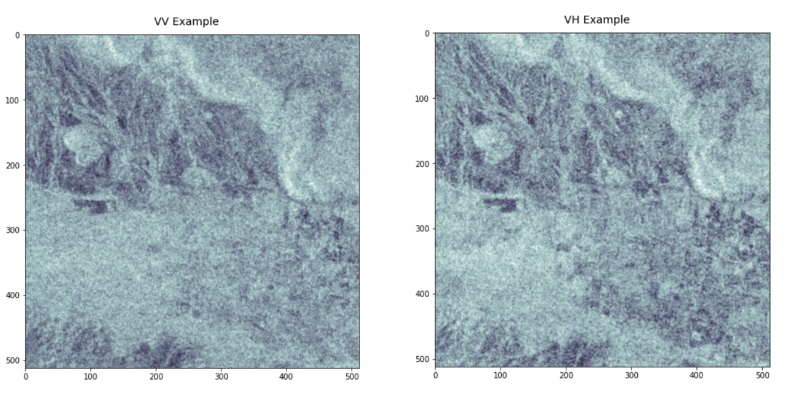

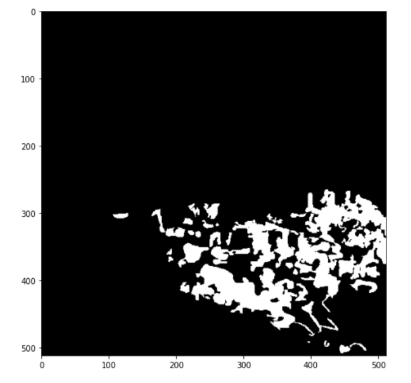

Vamos então importar as bibliotecas, funções e dados necessários:

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import pandas as pd
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_csv = 'drive/My Drive/Datasets/Flood_challenge/flood-training-metadata.csv'

In [ ]:
metadata = pd.read_csv(path_csv)

In [ ]:
metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [ ]:
len(pd.unique(metadata.chip_id))

542

In [ ]:
path_images = 'drive/My Drive/Datasets/Flood_challenge/train_features'
path_labels = 'drive/My Drive/Datasets/Flood_challenge/train_labels'

Podemos usar Lee Filter para suavizar e remover o ruído das bandas S1:

In [ ]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

<ipython-input-9-85178c643845>:1: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
<ipython-input-9-85178c643845>:2: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


In [ ]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Vamos importar dados de entrada e máscaras:

In [ ]:
X = []
for pref in pd.unique(metadata.chip_id):
  import_vv = os.path.join(path_images,pref + '_vv.tif')
  import_vh = os.path.join(path_images,pref + '_vh.tif')
  with rasterio.open(import_vv) as src:
    vv = src.read()
  vv = vv.transpose([1,2,0])
  vv = lee_filter(vv[:,:,0],5)
  with rasterio.open(import_vh) as src:
    vh = src.read()
  vh = vh.transpose([1,2,0])
  vh = lee_filter(vh[:,:,0],5)
  im = np.dstack((vv,vh))
  print(im.shape)
  X.append(im)
X = np.array(X)
print(X.shape)

(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 512, 2)
(512, 

In [ ]:
Y = []
for pref in pd.unique(metadata.chip_id):
  import_lb = os.path.join(path_labels,pref + '.tif')
  with rasterio.open(import_lb) as src:
    lb = src.read()
  lb = lb.transpose([1,2,0])
  print(lb.shape)
  Y.append(lb)
Y = np.array(Y)
print(Y.shape)

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 

Depois de converter para array numpy, vamos normalizar os dados para o intervalo de 0 a 1:

In [ ]:
X_int = cv2.normalize(X, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

In [ ]:
Y_int = np.where(Y==255,0,Y)

Podemos então plotar as duas bandas e a máscara:

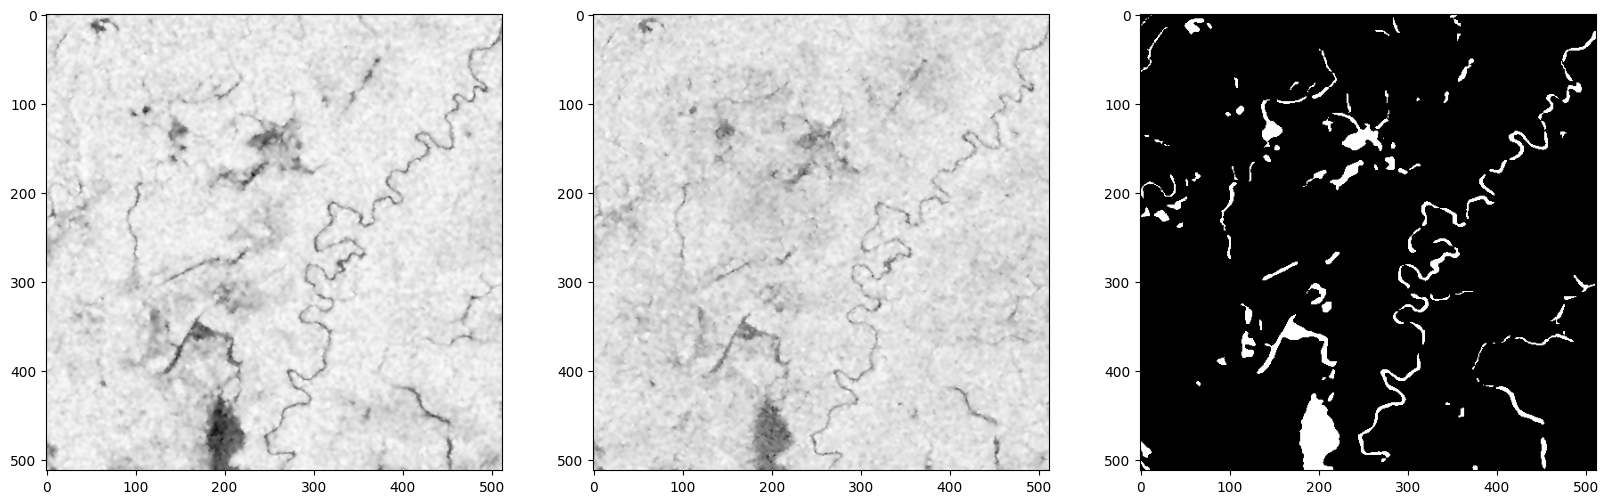

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1),
plt.imshow(X_int[10,:,:,0], cmap='Greys_r')
plt.subplot(1,3,2),
plt.imshow(X_int[10,:,:,1], cmap='Greys_r')
plt.subplot(1,3,3),
plt.imshow(Y_int[10,:,:,0], cmap='Greys_r')

Vamos dividir os dados em treinamento e teste:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_int, Y_int, test_size=0.25, random_state=10)

In [ ]:
y_train = y_train.astype('float')
y_test = y_test.astype('float')

In [ ]:
del X,Y, X_int, Y_int

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Concatenate, add, Conv2DTranspose, BatchNormalization, Dropout, Activation, Add, AveragePooling2D, Lambda, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, ZeroPadding2D, LeakyReLU
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import relu
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
from keras.models import load_model
from keras.models import model_from_json

Antes de implementar a U-Net, vamos ver a implementação do Jaccard e Dice loss, e Jaccard e Dice coeficiente:

In [ ]:
def jaccard_coef(y_true, y_pred,smooth=100):
  # __author__ = Vladimir Iglovikov
  intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
  sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

  jac = (intersection + smooth) / (sum_ - intersection + smooth)

  return K.mean(jac)

def jaccard_loss(y_true, y_pred):
  return 1 - jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Neste exemplo, usaremos o aumento de dados para gerar mais amostras de treinamento:

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2)

mask_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2)

In [ ]:
img_datagen.fit(x_train, augment=True,seed=1200)
mask_datagen.fit(y_train, augment=True,seed=1200)

In [ ]:
X=img_datagen.flow(x_train,batch_size=8,seed=1200)
Y=mask_datagen.flow(y_train,batch_size=8,seed=1200)

In [ ]:
train_generator = zip(X, Y)

In [ ]:
steps_per_epoch = len(x_train)//8
validation_steps = len(x_test)//8

Então vamos implementar a U-Net:

In [ ]:
upconv = True
droprate = 0.5
inputs = Input(shape=x_train.shape[1:])
conv1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


pool1 = BatchNormalization()(pool1)
conv2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(droprate)(pool2)

pool2 = BatchNormalization()(pool2)
conv3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(droprate)(pool3)

pool3 = BatchNormalization()(pool3)
conv4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(droprate)(pool4)

pool4 = BatchNormalization()(pool4)
conv5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
pool5 = Dropout(droprate)(pool5)

pool5 = BatchNormalization()(pool5)
conv6 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool5)
conv6 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv6)
conv6 = Dropout(droprate)(conv6)

if upconv:
  up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6), conv5])
else:
  up6 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv5])
up6 = BatchNormalization()(up6)
conv7 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up6)
conv7 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv7)
conv7 = Dropout(droprate)(conv7)

if upconv:
  up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7), conv4])
else:
  up7 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv4])
up7 = BatchNormalization()(up7)
conv8 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up7)
conv8 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv8)
conv8 = Dropout(droprate)(conv8)

if upconv:
  up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8), conv3])
else:
  up8 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv3])
up8 = BatchNormalization()(up8)
conv9 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up8)
conv9 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv9)
conv9 = Dropout(droprate)(conv9)

if upconv:
  up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9), conv2])
else:
  up9 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv2])
up9 = BatchNormalization()(up9)
conv10 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up9)
conv10 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv10)
conv10 = Dropout(droprate)(conv10)

if upconv:
  up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10), conv1])
else:
  up10 = concatenate([UpSampling2D(size=(2, 2))(conv10), conv1])
up10 = BatchNormalization()(up10)
conv11 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up10)
conv11 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv11)


conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)
model = Model(inputs=inputs, outputs=conv12)

model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = jaccard_loss, metrics=[jaccard_coef, 'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128, 128, 25  1024       ['concatenate_2[0][0]']          
 rmalization)                   6)                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 12  295040      ['batch_normalization_7[0][0]']  
                                8)                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_16[0][0]']              
                                8)                                                                
                                                                                                  
 dropout_7

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                              epochs=100, validation_data=(x_test,y_test))

<ipython-input-34-f0bb3fd73806>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,


Epoch 1/100
50/50 [==============================] - 75s 1s/step - loss: 0.8184 - jaccard_coef: 0.1816 - accuracy: 0.6871 - val_loss: 0.8425 - val_jaccard_coef: 0.1575 - val_accuracy: 0.8386
Epoch 2/100
50/50 [==============================] - 71s 1s/step - loss: 0.7010 - jaccard_coef: 0.2983 - accuracy: 0.7782 - val_loss: 0.8300 - val_jaccard_coef: 0.1700 - val_accuracy: 0.8394
Epoch 3/100
50/50 [==============================] - 55s 1s/step - loss: 0.5908 - jaccard_coef: 0.4106 - accuracy: 0.8358 - val_loss: 0.8244 - val_jaccard_coef: 0.1756 - val_accuracy: 0.8396
Epoch 4/100
50/50 [==============================] - 54s 1s/step - loss: 0.5426 - jaccard_coef: 0.4569 - accuracy: 0.8609 - val_loss: 0.8363 - val_jaccard_coef: 0.1637 - val_accuracy: 0.8387
Epoch 5/100
50/50 [==============================] - 55s 1s/step - loss: 0.5232 - jaccard_coef: 0.4787 - accuracy: 0.8670 - val_loss: 0.8286 - val_jaccard_coef: 0.1714 - val_accuracy: 0.8384
Epoch 6/100
50/50 [==========================

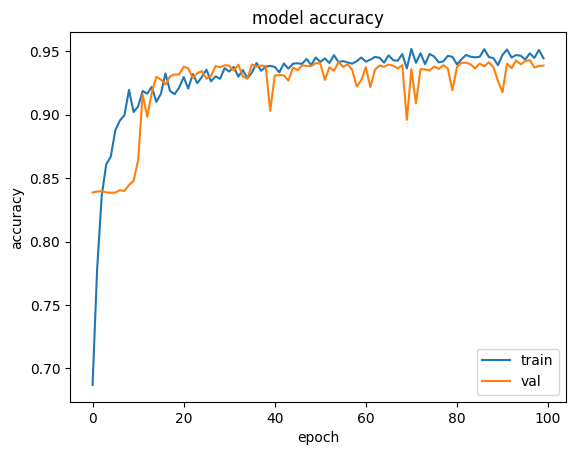

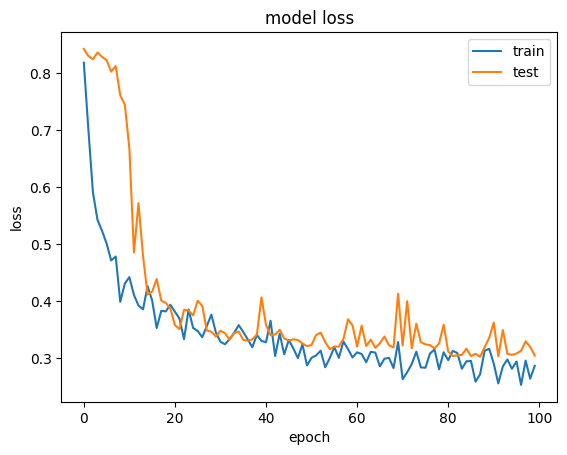

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
predict = model.predict(x_test)

5/5 [==============================] - 30s 673ms/step


In [ ]:
pred = np.round(predict)

In [ ]:
accuracy = accuracy_score(y_test.flatten(),pred.flatten())
print(accuracy)

0.9385725189657772


Por fim, vamos plotar um exemplo do resultado previsto em comparação com a máscara original:

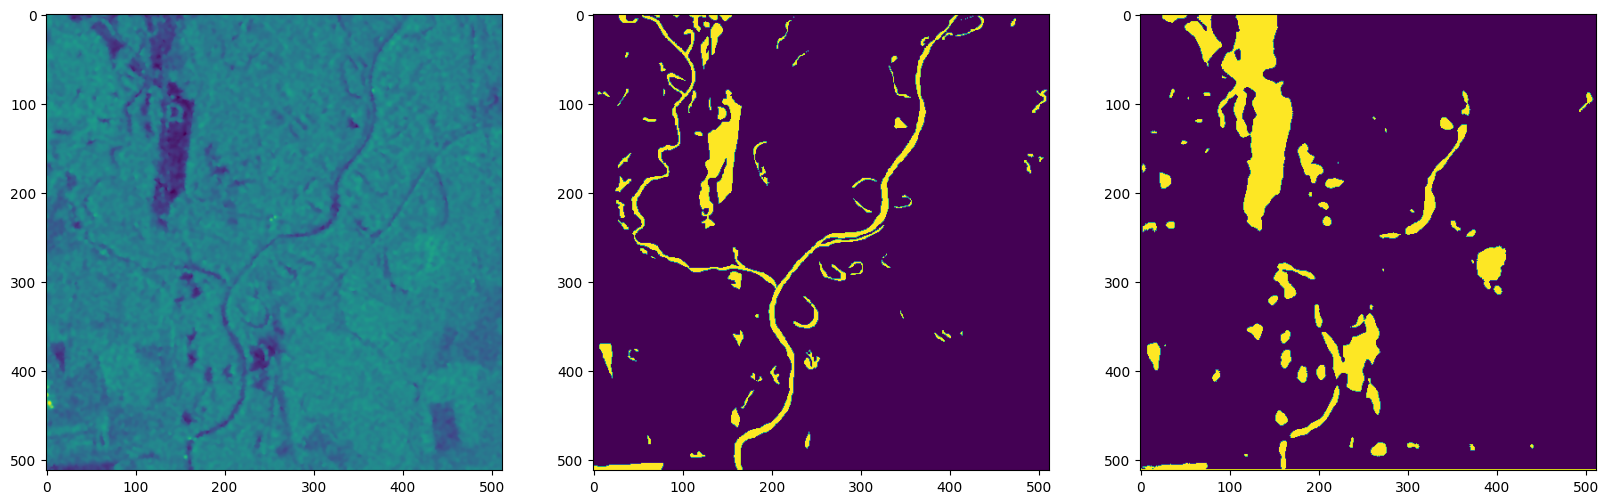

In [ ]:
i = 2
plt.figure(figsize=(20,8))
plt.subplot(1,3,1),
plt.imshow(x_test[i,:,:,0])
plt.subplot(1,3,2),
plt.imshow(y_test[i,:,:])
plt.subplot(1,3,3),
plt.imshow(pred[i,:,:,0])

In [ ]:
save_path = '/content/Results_img'
if not os.path.isdir(save_path):
  os.mkdir(save_path)

In [ ]:
for i in range(len(predict)):
  im = np.round(predict[i])
  full_im = im * 255
  full_im = full_im.astype('uint8')
  full_save_path = os.path.join(save_path,'Img_'+ str(i) + '.png')
  print(full_save_path)
  cv2.imwrite(full_save_path, full_im)

/content/Results_img/Img_0.png
/content/Results_img/Img_1.png
/content/Results_img/Img_2.png
/content/Results_img/Img_3.png
/content/Results_img/Img_4.png
/content/Results_img/Img_5.png
/content/Results_img/Img_6.png
/content/Results_img/Img_7.png
/content/Results_img/Img_8.png
/content/Results_img/Img_9.png
/content/Results_img/Img_10.png
/content/Results_img/Img_11.png
/content/Results_img/Img_12.png
/content/Results_img/Img_13.png
/content/Results_img/Img_14.png
/content/Results_img/Img_15.png
/content/Results_img/Img_16.png
/content/Results_img/Img_17.png
/content/Results_img/Img_18.png
/content/Results_img/Img_19.png
/content/Results_img/Img_20.png
/content/Results_img/Img_21.png
/content/Results_img/Img_22.png
/content/Results_img/Img_23.png
/content/Results_img/Img_24.png
/content/Results_img/Img_25.png
/content/Results_img/Img_26.png
/content/Results_img/Img_27.png
/content/Results_img/Img_28.png
/content/Results_img/Img_29.png
/content/Results_img/Img_30.png
/content/Results_i

### PSPNet

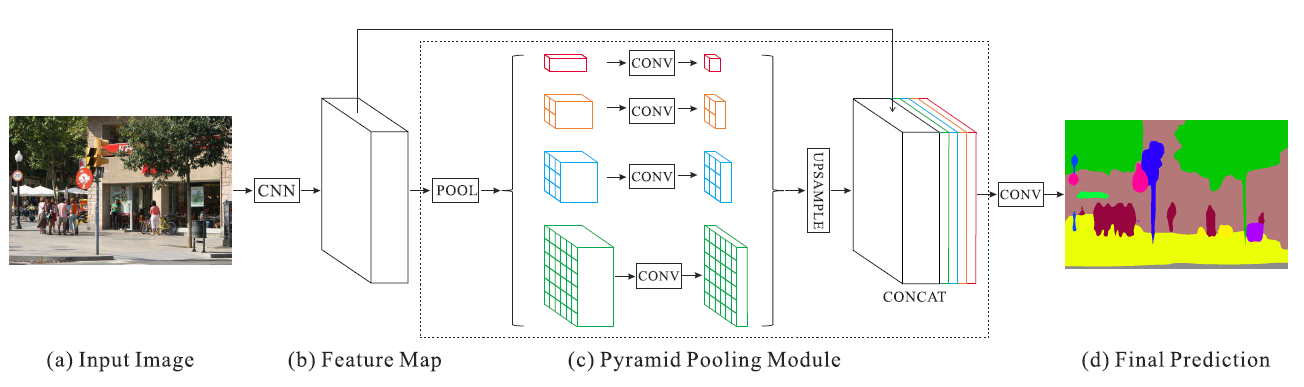

a) Imagem de entrada

Imagem de entrada de qualquer forma geralmente com dimensões maiores que (256, 256) alimenta a rede.

b) Mapa de recursos

Pega a imagem de entrada e constrói mapas de recursos para a imagem. Os mapas de recursos são extraídos alimentando a imagem usando aprendizado de transferência ou rede zero com convoluções dilatadas. Como os kernels de tamanho grande extraem informações mais úteis do que o kernel de tamanho pequeno, mas o custo de computação é maior, as convoluções dilatadas reúnem informações de área de tamanho grande com kernel de tamanho pequeno para taxas de dilatação mais altas para manter as dimensões iguais à imagem de entrada. Geralmente, blocos residuais com dilatações são usados para construir o recurso maps.No.of feature maps N é um hiperparâmetro e precisa ser ajustado para um bom resultado.

c) Módulo de agrupamento de pirâmides

Uma imagem contém objetos de tamanhos que variam de área pequena a grande área em diferentes regiões. Rede totalmente convolutiva (FCN), U-Net e outras redes constroem mapas de recursos aumentando a resolução e fazendo segmentação em diferentes níveis para segmentação de todos os objetos em todas as regiões. Mas no PSPNet para segmentar corretamente todos os objetos de tamanho, os mapas de recursos são agrupados em média em diferentes tamanhos de pool.
O pooling médio da sub-região é feito em diferentes escalas, como Global Average Pooling,(2x2),(3x3),(4x4),(6x6),(8x8)..
Após o agrupamento médio de N mapas de recursos com n tamanhos diferentes, os mapas de recursos em cada nível foram reduzidos para N/n mapas de recursos realizando convoluções 1*1.
Por exemplo, se N=512 mapas de recursos e n=4 tamanhos como Global Average Pooling,(2x2),(4x4),(8x8) então, em cada nível, 512 mapas de recursos são reduzidos para 126 mapas de recursos.
N/n mapas de recursos em cada nível de amostragem para ter as mesmas dimensões da imagem de entrada. Para upsampling , bilinear_interpolation ou convolution_transpose métodos usados em vez de upsampling simples.
A saída do Pyramid Pooling Module é uma concatenação de mapas de recursos básicos de b e mapas de recursos agrupados médios upsampled de c.

d) Previsão final

Os mapas de recursos 2 * N são alimentados para a camada de convolução e a previsão final das classes é gerada em como a camada de saída é construída, digamos diferentes canais para diferentes objetos ou canal único.

A PSPNet pode ser implementada usando os seguintes códigos:

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Concatenate, add, Conv2DTranspose, BatchNormalization, Dropout, Activation, Add, AveragePooling2D, Lambda, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, ZeroPadding2D, LeakyReLU
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import relu
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
from keras.models import load_model
from keras.models import model_from_json

In [ ]:
def jaccard_coef(y_true, y_pred,smooth=100):
  # __author__ = Vladimir Iglovikov
  intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
  sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

  jac = (intersection + smooth) / (sum_ - intersection + smooth)

  return K.mean(jac)

def jaccard_loss(y_true, y_pred):
  return 1 - jaccard_coef(y_true, y_pred)

In [ ]:
def conv_block(input_tensor, filters, strides, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, strides=strides, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


def identity_block(input_tensor, filters, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)

    return x


def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    h = input_tensor.shape[1].value
    w = input_tensor.shape[2].value

    for bin_size in bin_sizes:
        x = AveragePooling2D(pool_size=(h//bin_size, w//bin_size), strides=(h//bin_size, w//bin_size))(input_tensor)
        x = Conv2D(512, kernel_size=1, kernel_initializer='he_uniform')(x)
        x = Lambda(lambda x: tf.image.resize_images(x, (h, w)))(x)

        concat_list.append(x)

    return concatenate(concat_list)

In [ ]:
droprate = 0.5
inputs = Input((640, 640, 14))
conv_1 = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)

conv_2 = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)

conv_3 = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)

pool_1 = MaxPooling2D((2, 2), strides=(2, 2),)(conv_3)

conv_block1 = conv_block(pool_1, filters=[64, 64, 128], strides=(1, 1), d_rates=[1, 1, 1])
identity_block1 = identity_block(conv_block1, filters=[64, 64, 128], d_rates=[1, 1, 1])
identity_block2 = identity_block(identity_block1, filters=[64, 64, 128], d_rates=[1, 1, 1])

conv_block2 = conv_block(identity_block2, filters=[128, 128, 256], strides=(2, 2), d_rates=[1, 1, 1])
identity_block3 = identity_block(conv_block2, filters=[128, 128, 256], d_rates=[1, 1, 1])
identity_block4 = identity_block(identity_block3, filters=[128, 128, 256], d_rates=[1, 1, 1])
identity_block5 = identity_block(identity_block4, filters=[128, 128, 256], d_rates=[1, 1, 1])

conv_block3 = conv_block(identity_block5, filters=[256, 256, 512], strides=(2, 2), d_rates=[1, 1, 1])
identity_block6 = identity_block(conv_block3, filters=[256, 256, 512], d_rates=[1, 2, 1])
identity_block7 = identity_block(identity_block6, filters=[256, 256, 512], d_rates=[1, 2, 1])
identity_block8 = identity_block(identity_block7, filters=[256, 256, 512], d_rates=[1, 2, 1])
identity_block9 = identity_block(identity_block8, filters=[256, 256, 512], d_rates=[1, 2, 1])
identity_block10 = identity_block(identity_block9, filters=[256, 256, 512], d_rates=[1, 2, 1])

conv_block4 = conv_block(identity_block10, filters=[512, 512, 1024], strides=(1, 1), d_rates=[1, 4, 1])
identity_block11 = identity_block(conv_block4, filters=[512, 512, 1024], d_rates=[1, 4, 1])
identity_block12 = identity_block(identity_block11, filters=[512, 512, 1024], d_rates=[1, 4, 1])

pyramid_pooling_block1 = pyramid_pooling_block(identity_block12, [1, 2, 4, 8])

conv_4 = Conv2D(512,  (3, 3), kernel_initializer='he_uniform', padding='same')(pyramid_pooling_block1)
conv_4 = BatchNormalization()(conv_4)
conv_4 = Activation('relu')(conv_4)

conv_5 = Conv2D(1, (1, 1), kernel_initializer='he_uniform', padding='same')(conv_4)
conv_5 = Conv2DTranspose(1, (16, 16), strides=(8, 8), kernel_initializer='he_uniform', padding='same')(conv_5)
outputs = Activation('softmax')(conv_5)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = jaccard_loss, metrics=[jaccard_coef, 'accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 640, 640, 14) 0                                            
__________________________________________________________________________________________________
conv2d_367 (Conv2D)             (None, 640, 640, 32) 4064        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_337 (BatchN (None, 640, 640, 32) 128         conv2d_367[0][0]                 
__________________________________________________________________________________________________
activation_319 (Activation)     (None, 640, 640, 32) 0           batch_normalization_337[0][0]    
____________________________________________________________________________________________